### DATA620 - Project 3
#### Michael Ippolito
6/28/2022

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Project is due 7/5.

Source: Natural Language Processing with Python, exercise 6.10.2.

### Project Overview

This project focuses on contextless gender classification of names; i.e., all we are given is a name, with no sentences surrounding it for context. We'll split the model into three sets: training, devtest, and test (6900, 500, and 500 words, respectively). The model will be trained iteratively, with each iteration expanding on the previous. After each successive training session, the devtest set will be evaluated for accuracy. Following the final iteration, the test set will be evaluated to determine how well the model can be expected to perform on unseen data.


### Link to video presentation

[Video](https://github.com/mmippolito/cuny_data620_project3/blob/main/ippolito_video.mp4?raw=true)

In [148]:
# Load libraries
import matplotlib.pyplot as plt
import csv
import os
import requests
import numpy as np
from scipy import stats
import pandas as pd
from collections import Counter
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'jupyterlab'    # set ploty renderer so graphs show up in HTML output
from nltk.corpus import names
from nltk.classify import apply_features
import nltk
import random
import math


### Data Preparation

The names will be loaded from the NLTK Names corpus. Then they will be split into test, devtest, and training sets.


In [26]:
# Load names into list and shuffle
labeled_names = ([(name, 'male') for name in names.words('male.txt')] + [(name, 'female') for name in names.words('female.txt')])
random.shuffle(labeled_names)

# Split into training, devtest, and test sets
test_names = labeled_names[:500]
devtest_names = labeled_names[500:1000]
train_names = labeled_names[1000:]


### Gender Features

An array will be defined, i_legend, as a key to indicate which features are part of the featuresets during this iteration. Then a function will be defined to generate the featureset using the features for this iteration of the model.


In [152]:
# Array to store explanation for what each iteration means
i_legend = [
    "first letter only",
    "last letter only",
    "last two letters",
    "name length",
    "count of each letter",
    "name contains letter",
    "first two letters",
    "2letter counts",
    "3letter counts",
    "4letter counts",
    "first/last letter",
    "vowel count",
    "consonant count"
]

# Function to generate features
def gender_features(name, i):
    features = {}
    if i > -1:
        features["prefix1"] = name[0].lower()
    if i > 0:
        features["suffix1"] = name[-1].lower()
    if i > 1:
        features["suffix2"] = name[-2:].lower()
    if i > 2:
        features["len"] = len(name)
    for letter in 'abcdefghijklmnopqrstuvwxyz-':
        if i > 3:
            features["count({})".format(letter)] = name.lower().count(letter)
        if i > 4:
            features["has({})".format(letter)] = (letter in name.lower())
    if i > 5:
        features["prefix2"] = name[:2].lower()
    if i > 6:
        for nletter in find_nletters(name.lower(), 2):
            features["has_2letter({})".format(nletter)] = True
    if i > 7:
        for nletter in find_nletters(name.lower(), 3):
            features["has_3letter({})".format(nletter)] = True
    if i > 8:
        for nletter in find_nletters(name.lower(), 4):
            features["has_4letter({})".format(nletter)] = True
    if i > 9:
        features["first_last"] = name[0].lower() + name[-1:].lower()
    if i > 10:
        features["vowel_count"] = sum([name.lower().count(v) for v in ['a', 'e', 'i', 'o', 'u']])
    if i > 11:
        features["consonant_count"] = len(name) - sum([name.lower().count(v) for v in ['a', 'e', 'i', 'o', 'u']])
    return features


### N-Letter Sequences

In n-letter prefixes and suffixes, I explored n-letter sequences at any arbitrary position within each name. To that end, I defined a function that extracted each n-letter sequence. To aid in exploratory data analysis, I also defined a function to compute the entropy of each n-letter combination. Then the n-letter sequences were explored to see if if there was sufficient justification to use it in a featureset. As shown, the entropy of the best four-letter sequences was very low, indicating there is the potential for good information gain by using this featureset.


In [139]:
# Function to find n-letter sequences
def find_nletters(name, n):
    nletters = []
    if len(name) >= n:
        for j in range(0, len(name) - n + 1):
            nletters.append(name[j:(j+n)].lower())
    return nletters

# Function to return entropy
def entropy(male, female):
    male += 1        # prevent math errros
    female += 1      # prevent math errors
    p_male = male / (male + female)
    entropy_male = p_male * math.log(p_male, 2)
    p_female = 1 - p_male
    entropy_female = p_female * math.log(p_female, 2)
    return -(entropy_male + entropy_female)

# EDA
for n in range(2, 5):

    # Generate nletters for names - EDA
    print("n:", n)
    nletter_counts = {}
    for name, gender in labeled_names:
        nletters = find_nletters(name, n)
        for nletter in nletters:
            if nletter not in nletter_counts.keys():
                nletter_counts[nletter] = {'male': 0, 'female': 0}
            nletter_counts[nletter][gender] += 1

    # Look at nletter counts with the lowest entropy
    for k, i in nletter_counts.items():
        i['entropy'] = entropy(i['male'], i['female'])

    # EDA - look at nletter counts
    ct = 0
    for k, i in sorted(nletter_counts.items(), key=lambda k: k[1]['entropy'], reverse = False):
        ct += 1
        print(k, i)
        if ct > 10:
            break
    print()


n: 2
wo {'male': 29, 'female': 0, 'entropy': 0.20559250818508293}
gw {'male': 0, 'female': 16, 'entropy': 0.3095434291503252}
rv {'male': 28, 'female': 1, 'entropy': 0.3451173149449531}
hu {'male': 38, 'female': 2, 'entropy': 0.3712323266408755}
fo {'male': 35, 'female': 2, 'entropy': 0.3912435636292555}
uz {'male': 0, 'female': 11, 'entropy': 0.39124356362925566}
a- {'male': 0, 'female': 9, 'entropy': 0.4394969869215134}
ht {'male': 9, 'female': 0, 'entropy': 0.4394969869215134}
nf {'male': 8, 'female': 0, 'entropy': 0.46899559358928117}
gs {'male': 8, 'female': 0, 'entropy': 0.46899559358928117}
hm {'male': 8, 'female': 0, 'entropy': 0.46899559358928117}

n: 3
nna {'male': 1, 'female': 108, 'entropy': 0.1301627906682594}
bet {'male': 0, 'female': 36, 'entropy': 0.17556502585750278}
tte {'male': 2, 'female': 99, 'entropy': 0.18999075553626754}
cin {'male': 0, 'female': 27, 'entropy': 0.21639693245126468}
eta {'male': 0, 'female': 27, 'entropy': 0.21639693245126468}
ina {'male': 6, 'fe

### Training Function

This is the function that trains the model. First, the featureset for this iteration is generated using the features specified for this iteration number. Then the featuresets are applied to the training and devtest sets. A naive Bayes classifier is instantiated and trained using the training set, then the accuracy of the devtest set is assessed.


In [153]:
# Function to train the model
def train_model(i):

    # Create feature sets
    print("Training model, iteration #" + str(i))
    print("\tFeatures:")
    for j in range(0, i+1):
        print("\t\t" + i_legend[j])
    featuresets = [(gender_features(n, i), gender) for (n, gender) in labeled_names]
    print("\tExample featureset:", labeled_names[0], featuresets[0])

    # Apply the features to the training and devtest set
    train_set = [(gender_features(n, i), gender) for (n, gender) in train_names]
    devtest_set = [(gender_features(n, i), gender) for (n, gender) in devtest_names]

    # Use a naive Bayes classifier to train the model
    classifier = nltk.NaiveBayesClassifier.train(train_set)
    
    # Get the accuracy of the devtest set
    result = nltk.classify.accuracy(classifier, devtest_set)
    print("\tAccuacy:", result)
    classifier.show_most_informative_features(10)

    # Generate list of names the model got wrong
    errors = []
    for (name, tag) in devtest_names:
        guess = classifier.classify(gender_features(name, i))
        if guess != tag:
            errors.append((tag, guess, name))

    # Print out the first few wrong names
    errlist = ['correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name) for (tag, guess, name) in sorted(errors)]
    print("\tFirst 10 errors:")
    for j in range(0, 10):
        print("\t\t" + errlist[j])

    # Return the accuracy result
    return result


### Model Training

The model is trained iteratively, and the accuracy results are recorded.


In [143]:
# Main program: train the model and record the accuracy for each iteration
results = []

# Train the model
for i in range(0, len(i_legend)):
    
    # Train the model and append the accuracy score to the results array
    print("------------------------------------------------------------------------------")
    results.append(train_model(i))
    print()


------------------------------------------------------------------------------
Training model, iteration #0
	Features:
		first letter only
	Example featureset: ('Lenora', 'female') ({'prefix1': 'l'}, 'female')
	Accuacy: 0.652
Most Informative Features
                 prefix1 = 'w'              male : female =      4.7 : 1.0
                 prefix1 = 'q'              male : female =      2.9 : 1.0
                 prefix1 = 'x'              male : female =      2.9 : 1.0
                 prefix1 = 'u'              male : female =      2.6 : 1.0
                 prefix1 = 'k'            female : male   =      2.3 : 1.0
                 prefix1 = 'h'              male : female =      2.1 : 1.0
                 prefix1 = 'z'              male : female =      2.0 : 1.0
                 prefix1 = 'y'              male : female =      1.8 : 1.0
                 prefix1 = 'c'            female : male   =      1.7 : 1.0
                 prefix1 = 'l'            female : male   =      1.7 : 1.

### Model Results

List and plot the model results.

Results:
0   0.6520 first letter only             
1   0.7500 last letter only              
2   0.7660 last two letters              
3   0.7700 name length                   
4   0.7900 count of each letter          
5   0.7940 name contains letter          
6   0.7900 first two letters             
7   0.8040 2letter counts                
8   0.8280 3letter counts                
9   0.8460 4letter counts                
10  0.8380 first/last letter             
11  0.8320 vowel count                   
12  0.8320 consonant count               



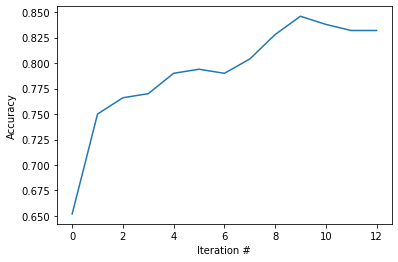

In [146]:
# Show results
print("Results:")
for i, result in enumerate(results):
    print('{:<3s} {:.4f} {:<30s}'.format(str(i), result, i_legend[i]))
print()

# Plot results
x = range(0, len(i_legend))
plt.plot(x, results)
plt.xlabel('Iteration #')
plt.ylabel('Accuracy')
plt.show()


### Final Evaluation

Select the best model run and evaluate the test set against the featureset of that run.


In [142]:
# Final training session using the selected featureset
best_run = 9
train_set = [(gender_features(n, best_run), gender) for (n, gender) in train_names]
classifier = nltk.NaiveBayesClassifier.train(train_set)

# Evaluation of test set
test_set = [(gender_features(n, best_run), gender) for (n, gender) in test_names]
result_validation = nltk.classify.accuracy(classifier, test_set)
print("\tAccuacy of test set:", result_validation)
classifier.show_most_informative_features(20)


	Accuacy of test set: 0.804
Most Informative Features
                 suffix2 = 'la'           female : male   =     71.2 : 1.0
                 suffix2 = 'ia'           female : male   =     36.8 : 1.0
                 suffix1 = 'a'            female : male   =     35.6 : 1.0
                 suffix2 = 'sa'           female : male   =     31.5 : 1.0
         has_2letter(rv) = True             male : female =     29.2 : 1.0
                 suffix1 = 'k'              male : female =     28.6 : 1.0
                 suffix2 = 'us'             male : female =     28.1 : 1.0
                 suffix1 = 'f'              male : female =     26.8 : 1.0
         has_2letter(lt) = True             male : female =     25.7 : 1.0
                 suffix2 = 'ra'           female : male   =     25.1 : 1.0
        has_3letter(ham) = True             male : female =     24.6 : 1.0
                 suffix2 = 'ta'           female : male   =     23.3 : 1.0
                 suffix2 = 'ld'             ma

### Analysis and Conclusion

The best model run was no. 9, which exhibited good information gain using the 4-letter sequence featureset. This run yielded an accuracy score of 84.6%. One point of interest is that the model's performance seemed to decline after the tenth run, likely the result of overitting.

When the final test data was evaluated, the result was 80.4%, somewhat lower than the result from the training data. This is to be expected, as the training set will have some idiosyncracies not found in the test set; conversely, the test set will have data that the training set has never set--which is the entire point of doing the evaluation on a "blind" data set.
